In [ ]:
#%pip install numpy matplotlib h5py scipy tensorflow

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import scipy
from PIL import Image
from scipy import ndimage
from tensorflow import keras

# Clases y funciones

## Función de carga de datos

In [3]:
from pathlib import Path
import os
import csv
import numpy as np
from PIL import Image

def load_dataset(
    csv_path='archive/flower_images/flower_images/flower_labels.csv',
    images_dir='archive/flower_images/flower_images',
    img_size=(64, 64),
    test_size=0.2,
    seed=42,
    normalize=True,
    ):
    """Load images and labels from a CSV file.

    CSV format: file,label
    - file: image filename (e.g., 0001.png)
    - label: integer class id

    Returns:
        train_set_x_orig: (m_train, H, W, 3) float32
        train_set_y_orig: (1, m_train) int64
        test_set_x_orig: (m_test, H, W, 3) float32
        test_set_y_orig: (1, m_test) int64
        classes: (num_classes,) array of class names (strings)
    """
    csv_path = Path(csv_path)
    images_dir = Path(images_dir)

    if not csv_path.exists():
        raise FileNotFoundError(f"CSV not found: {csv_path.resolve()}")
    if not images_dir.exists():
        raise FileNotFoundError(f"Images directory not found: {images_dir.resolve()}")

    files = []
    labels = []
    with csv_path.open('r', newline='') as f:
        reader = csv.DictReader(f)
        if 'file' not in reader.fieldnames or 'label' not in reader.fieldnames:
            raise ValueError(f"CSV must have columns 'file' and 'label'. Found: {reader.fieldnames}")
        for row in reader:
            files.append(row['file'])
            labels.append(int(row['label']))

    labels = np.array(labels, dtype=np.int64)
    max_label = int(labels.max()) if labels.size else -1
    classes = np.array([str(i) for i in range(max_label + 1)])

    # Load images
    X = []
    y = []
    for fname, label in zip(files, labels):
        img_path = images_dir / fname
        if not img_path.is_file():
            # Skip missing files silently (or raise if you prefer)
            continue
        img = Image.open(img_path)
        img = img.resize(img_size)
        if img.mode != 'RGB':
            img = img.convert('RGB')
        X.append(np.array(img, dtype=np.float32))
        y.append(label)

    if len(X) == 0:
        raise ValueError("No images were loaded. Check paths and CSV content.")

    X = np.stack(X, axis=0)  # (m, H, W, 3)
    y = np.array(y, dtype=np.int64)
    if normalize:
        X = X / 255.0

    # Stratified split train/test
    rng = np.random.default_rng(seed)
    train_idx = []
    test_idx = []
    for lbl in np.unique(y):
        idx = np.where(y == lbl)[0]
        rng.shuffle(idx)
        n = idx.size
        if n <= 1:
            train_idx.extend(idx.tolist())
            continue
        n_test = int(round(n * test_size))
        n_test = max(1, min(n - 1, n_test))
        test_idx.extend(idx[:n_test].tolist())
        train_idx.extend(idx[n_test:].tolist())

    train_idx = np.array(train_idx, dtype=np.int64)
    test_idx = np.array(test_idx, dtype=np.int64)
    rng.shuffle(train_idx)
    rng.shuffle(test_idx)

    train_set_x_orig = X[train_idx]
    train_set_y_orig = y[train_idx].reshape(1, -1)
    test_set_x_orig = X[test_idx]
    test_set_y_orig = y[test_idx].reshape(1, -1)

    print(f"Training set: {train_set_x_orig.shape}, {train_set_y_orig.shape}")
    print(f"Test set: {test_set_x_orig.shape}, {test_set_y_orig.shape}")
    print(f"Classes: {classes}")

    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

## Implementación del modelo

### Función de activación

In [4]:
# GRADED FUNCTION: sigmoid
from typing import Any, Dict, List, Tuple, Union, TypedDict

class Grads(TypedDict):
    dw: np.ndarray
    db: float

class Params(TypedDict):
    w: np.ndarray
    b: float

def sigmoid(z: Union[float, np.ndarray]) -> Union[float, np.ndarray]:
    """
    Compute the sigmoid of z (implementación estable numéricamente).

    Nota: retorna `float64` para arrays para mejorar estabilidad numérica.

    Arguments:
    z -- A scalar or numpy array of any size.

    Return:
    s -- sigmoid(z)
    """
    z_arr = np.asarray(z)
    z64 = z_arr.astype(np.float64, copy=False)
    out = np.empty_like(z64, dtype=np.float64)
    pos = z64 >= 0
    out[pos] = 1.0 / (1.0 + np.exp(-z64[pos]))
    exp_z = np.exp(z64[~pos])
    out[~pos] = exp_z / (1.0 + exp_z)
    if np.isscalar(z):
        return float(out)
    return out

### Función de inicialización

In [5]:
# GRADED FUNCTION: initialize_with_zeros

def initialize_with_zeros(dim: int) -> Tuple[np.ndarray, float]:
    """
    This function creates a vector of zeros of shape (dim, 1) for w and initializes b to 0.

    Argument:
    dim -- size of the w vector we want (or number of parameters in this case)

    Returns:
    w -- initialized vector of shape (dim, 1)
    b -- initialized scalar (corresponds to the bias)
    """

    ### START CODE HERE ### (≈ 1 line of code)
    w = np.zeros(shape=(dim, 1))
    b = 0.0
    ### END CODE HERE ###

    assert(w.shape == (dim, 1))
    assert(isinstance(b, float) or isinstance(b, int))

    return w, b

### Función de propagación

In [6]:
# GRADED FUNCTION: propagate

def propagate(w: np.ndarray, b: float, X: np.ndarray, Y: np.ndarray, lambda_: float = 0.0) -> Tuple[Grads, float]:
    """
    Implement the cost function and its gradient for the propagation explained above

    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of size (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat) of size (1, number of examples)
    lambda_ -- L2 regularization strength (0.0 disables regularization)

    Return:
    cost -- negative log-likelihood cost for logistic regression
    dw -- gradient of the loss with respect to w, thus same shape as w
    db -- gradient of the loss with respect to b, thus same shape as b

    Tips:
    - Write your code step by step for the propagation
    """

    m = X.shape[1]

    # FORWARD PROPAGATION (FROM X TO COST)
    ### START CODE HERE ### (≈ 2 lines of code)
    Z = np.dot(w.T, X) + b  # (1, m)
    A = sigmoid(Z)          # (1, m)
    # Costo estable numéricamente: evita log(0) aunque A sature a 0/1
    # + regularización L2: (lambda_/(2m)) * ||w||^2
    cost = (1.0 / m) * np.sum(np.logaddexp(0.0, Z) - Y * Z) + (lambda_ / (2.0 * m)) * np.sum(w * w)
    ### END CODE HERE ###

    # BACKWARD PROPAGATION (TO FIND GRAD)
    ### START CODE HERE ### (≈ 2 lines of code)
    dw = (1 / m) * np.dot(X, (A - Y).T) + (lambda_ / m) * w
    db = float((1 / m) * np.sum(A - Y))
    ### END CODE HERE ###

    assert(dw.shape == w.shape)
    assert(isinstance(db, float))
    cost = np.squeeze(cost)
    assert(cost.shape == ())

    grads: Grads = {"dw": dw,
             "db": db}

    return grads, float(cost)

### Función de optimización

In [7]:
# GRADED FUNCTION: optimize

def optimize(
    w: np.ndarray,
    b: float,
    X: np.ndarray,
    Y: np.ndarray,
    num_iterations: int,
    learning_rate: float,
    print_cost: bool = False,
    lambda_: float = 0.0,
) -> Tuple[Params, Grads, List[float]]:
    """
    This function optimizes w and b by running a gradient descent algorithm

    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of shape (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat), of shape (1, number of examples)
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    print_cost -- True to print the loss every 100 steps
    lambda_ -- L2 regularization strength (0.0 disables regularization)

    Returns:
    params -- dictionary containing the weights w and bias b
    grads -- dictionary containing the gradients of the weights and bias with respect to the cost function
    costs -- list of all the costs computed during the optimization, this will be used to plot the learning curve.

    Tips:
    You basically need to write down two steps and iterate through them:
        1) Calculate the cost and the gradient for the current parameters. Use propagate().
        2) Update the parameters using gradient descent rule for w and b.
    """

    costs: List[float] = []

    for i in range(num_iterations):

        # Cost and gradient calculation (≈ 1-4 lines of code)
        ### START CODE HERE ###
        grads, cost = propagate(w, b, X, Y, lambda_=lambda_)
        ### END CODE HERE ###

        # Retrieve derivatives from grads
        dw = grads["dw"]
        db = grads["db"]

        # update rule (≈ 2 lines of code)
        ### START CODE HERE ###
        w = w - learning_rate * dw  # need to broadcast
        b = b - learning_rate * db
        ### END CODE HERE ###

        # Record the costs
        if i % 100 == 0:
            costs.append(float(cost))

        # Print the cost every 100 training examples
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" % (i, cost))

    params: Params = {"w": w,
              "b": float(b)}

    grads_out: Grads = {"dw": dw,
             "db": float(db)}

    return params, grads_out, costs

### Función de predicción

In [8]:
# GRADED FUNCTION: predict

def predict(w: np.ndarray, b: float, X: np.ndarray) -> np.ndarray:
    '''
    Predict whether the label is 0 or 1 using learned logistic regression parameters (w, b)

    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of size (num_px * num_px * 3, number of examples)

    Returns:
    Y_prediction -- a numpy array (vector) containing all predictions (0/1) for the examples in X
    '''

    m = X.shape[1]
    Y_prediction = np.zeros((1, m))
    w = w.reshape(X.shape[0], 1)

    # Compute vector "A" predicting the probabilities of a cat being present in the picture
    ### START CODE HERE ### (≈ 1 line of code)
    A = sigmoid(np.dot(w.T, X) + b)
    ### END CODE HERE ###

    for i in range(A.shape[1]):
        # Convert probabilities a[0,i] to actual predictions p[0,i]
        ### START CODE HERE ### (≈ 4 lines of code)
        Y_prediction[0, i] = 1 if A[0, i] > 0.5 else 0
        ### END CODE HERE ###

    assert(Y_prediction.shape == (1, m))

    return Y_prediction

### Construcción del modelo

In [9]:
# GRADED FUNCTION: model

def model(
    X_train: np.ndarray,
    Y_train: np.ndarray,
    X_test: np.ndarray,
    Y_test: np.ndarray,
    num_iterations: int = 2000,
    learning_rate: float = 0.5,
    lambda_: float = 0.0,
    print_cost: bool = False,
 ) -> Dict[str, Any]:
    """
    Builds the logistic regression model by calling the function you've implemented previously

    Arguments:
    X_train -- training set represented by a numpy array of shape (num_px * num_px * 3, m_train)
    Y_train -- training labels represented by a numpy array (vector) of shape (1, m_train)
    X_test -- test set represented by a numpy array of shape (num_px * num_px * 3, m_test)
    Y_test -- test labels represented by a numpy array (vector) of shape (1, m_test)
    num_iterations -- hyperparameter representing the number of iterations to optimize the parameters
    learning_rate -- hyperparameter representing the learning rate used in the update rule of optimize()
    lambda_ -- L2 regularization strength (0.0 disables regularization)
    print_cost -- Set to true to print the cost every 100 iterations

    Returns:
    d -- dictionary containing information about the model.
    """

    ### START CODE HERE ###
    # initialize parameters with zeros (≈ 1 line of code)
    w, b = initialize_with_zeros(X_train.shape[0])

    # Gradient descent (≈ 1 line of code)
    parameters, grads, costs = optimize(
        w,
        b,
        X_train,
        Y_train,
        num_iterations=num_iterations,
        learning_rate=learning_rate,
        print_cost=print_cost,
        lambda_=lambda_,
    )

    # Retrieve parameters w and b from dictionary "parameters"
    w = parameters["w"]
    b = parameters["b"]

    # Predict test/train set examples (≈ 2 lines of code)
    Y_prediction_test = predict(w, b, X_test)
    Y_prediction_train = predict(w, b, X_train)

    ### END CODE HERE ###

    # Print train/test Errors
    print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
    print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))


    d: Dict[str, Any] = {"costs": costs,
         "Y_prediction_test": Y_prediction_test,
         "Y_prediction_train" : Y_prediction_train,
         "w" : w,
         "b" : b,
         "learning_rate" : learning_rate,
         "lambda_": float(lambda_),
         "num_iterations": num_iterations}

    return d

### Versión multiclase: Softmax (implementación propia)

> Esta sección implementa **regresión logística multiclase** (Softmax) desde cero.
- A diferencia de One-vs-Rest, aquí se entrena **un solo modelo** con $K$ salidas.
- Se usa una pérdida estable numéricamente (log-sum-exp) y soporta regularización L2 con `lambda_`.

In [10]:
# Implementación propia: Softmax Regression (multiclase)
from typing import Optional
from typing import TypedDict

class SoftmaxGrads(TypedDict):
    dW: np.ndarray
    db: np.ndarray

class SoftmaxParams(TypedDict):
    W: np.ndarray
    b: np.ndarray

def one_hot(Y: np.ndarray, num_classes: int) -> np.ndarray:
    """
    Y: (1, m) con enteros 0..K-1 -> retorna (K, m)
    """
    Y_int = Y.astype(int).reshape(-1)
    m = Y_int.size
    out = np.zeros((num_classes, m), dtype=np.float64)
    out[Y_int, np.arange(m)] = 1.0
    return out

def softmax(Z: np.ndarray) -> np.ndarray:
    """
    Softmax estable numéricamente.
    Z: (K, m) -> retorna P: (K, m) con sum_k P[k,i] = 1
    """
    Z64 = Z.astype(np.float64, copy=False)
    Z_shift = Z64 - np.max(Z64, axis=0, keepdims=True)
    exp_Z = np.exp(Z_shift)
    return exp_Z / np.sum(exp_Z, axis=0, keepdims=True)

def initialize_softmax(num_classes: int, n_features: int) -> SoftmaxParams:
    W = np.zeros((num_classes, n_features), dtype=np.float64)
    b = np.zeros((num_classes, 1), dtype=np.float64)
    return {"W": W, "b": b}

def propagate_softmax(
    W: np.ndarray,
    b: np.ndarray,
    X: np.ndarray,
    Y_int: np.ndarray,
    lambda_: float = 0.0,
 ) -> tuple[SoftmaxGrads, float]:
    """
    X: (n_features, m)
    Y_int: (1, m) con enteros 0..K-1
    W: (K, n_features)
    b: (K, 1)

    Retorna grads y costo (cross-entropy + L2).
    """
    m = X.shape[1]
    K = W.shape[0]

    Z = (W @ X) + b  # (K, m)
    # Costo estable con log-sum-exp
    Z64 = Z.astype(np.float64, copy=False)
    Z_shift = Z64 - np.max(Z64, axis=0, keepdims=True)
    logsumexp = np.log(np.sum(np.exp(Z_shift), axis=0, keepdims=True))  # (1, m)
    log_probs = Z_shift - logsumexp  # (K, m)

    Y_oh = one_hot(Y_int, K)  # (K, m)
    data_loss = -(1.0 / m) * np.sum(Y_oh * log_probs)
    reg_loss = (lambda_ / (2.0 * m)) * np.sum(W * W)
    cost = float(data_loss + reg_loss)

    P = np.exp(log_probs)  # (K, m)
    dZ = (P - Y_oh)  # (K, m)
    dW = (1.0 / m) * (dZ @ X.T) + (lambda_ / m) * W
    db = (1.0 / m) * np.sum(dZ, axis=1, keepdims=True)

    grads: SoftmaxGrads = {"dW": dW, "db": db}
    return grads, cost

def optimize_softmax(
    X: np.ndarray,
    Y_int: np.ndarray,
    num_classes: int,
    num_iterations: int = 2000,
    learning_rate: float = 0.05,
    lambda_: float = 0.0,
    print_cost: bool = False,
 ) -> tuple[SoftmaxParams, list[float]]:
    n_features = X.shape[0]
    params = initialize_softmax(num_classes, n_features)
    W = params["W"]
    b = params["b"]

    costs: list[float] = []
    for i in range(num_iterations):
        grads, cost = propagate_softmax(W, b, X, Y_int, lambda_=lambda_)
        W = W - learning_rate * grads["dW"]
        b = b - learning_rate * grads["db"]

        if i % 100 == 0:
            costs.append(float(cost))
            if print_cost:
                print(f"Cost after iteration {i}: {cost:.6f}")

    return {"W": W, "b": b}, costs

def predict_softmax(W: np.ndarray, b: np.ndarray, X: np.ndarray) -> np.ndarray:
    Z = (W @ X) + b  # (K, m)
    P = softmax(Z)
    return np.argmax(P, axis=0).reshape(1, -1)

# Carga de datos y entrenamientos

In [11]:
# Load data from Google Drive (only if running in Google Colab)

try:
    from google.colab import drive  # type: ignore
    drive.mount('/content/drive')
except Exception as e:
    print("Not running in Colab; skipping Drive mount.")

Not running in Colab; skipping Drive mount.


In [12]:
train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, classes = load_dataset()

Training set: (168, 64, 64, 3), (1, 168)
Test set: (42, 64, 64, 3), (1, 42)
Classes: ['0' '1' '2' '3' '4' '5' '6' '7' '8' '9']


y = [5], it's a '5' picture.


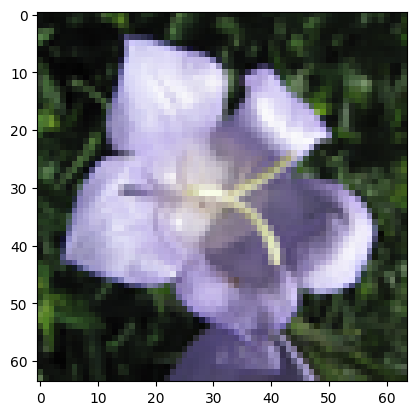

In [13]:
index = 0
plt.imshow(train_set_x_orig[index])
print ("y = " + str(train_set_y[:,index]) + ", it's a '" + classes[int(np.squeeze(train_set_y[:,index]))] +  "' picture.")

In [14]:
### START CODE HERE ### (≈ 3 lines of code)
m_train = train_set_y.shape[1]
m_test = test_set_y.shape[1]
num_px = train_set_x_orig.shape[1]
### END CODE HERE ###

print ("Number of training examples: m_train = " + str(m_train))
print ("Number of testing examples: m_test = " + str(m_test))
print ("Height/Width of each image: num_px = " + str(num_px))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_set_x shape: " + str(train_set_x_orig.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x shape: " + str(test_set_x_orig.shape))
print ("test_set_y shape: " + str(test_set_y.shape))

Number of training examples: m_train = 168
Number of testing examples: m_test = 42
Height/Width of each image: num_px = 64
Each image is of size: (64, 64, 3)
train_set_x shape: (168, 64, 64, 3)
train_set_y shape: (1, 168)
test_set_x shape: (42, 64, 64, 3)
test_set_y shape: (1, 42)


In [15]:
# Reshape the training and test examples

### START CODE HERE ### (≈ 2 lines of code)
train_set_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[0], -1).T
test_set_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[0], -1).T
### END CODE HERE ###

print ("train_set_x_flatten shape: " + str(train_set_x_flatten.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x_flatten shape: " + str(test_set_x_flatten.shape))
print ("test_set_y shape: " + str(test_set_y.shape))
print ("sanity check after reshaping: " + str(train_set_x_flatten[0:5,0]))

train_set_x_flatten shape: (12288, 168)
train_set_y shape: (1, 168)
test_set_x_flatten shape: (12288, 42)
test_set_y shape: (1, 42)
sanity check after reshaping: [0.05882353 0.07450981 0.0627451  0.04313726 0.05098039]


Clase 0: último costo = 0.019764341202428384
Clase 1: último costo = 0.014860754720501728
Clase 2: último costo = 0.009277130281423459
Clase 3: último costo = 0.019592920743508237
Clase 4: último costo = 0.00757560709173709
Clase 5: último costo = 0.022764158488574042
Clase 6: último costo = 0.016179409527230845
Clase 7: último costo = 0.008867042804242884
Clase 8: último costo = 0.016061539967628304
Clase 9: último costo = 0.01909242438877854
Train accuracy (OVR + sigmoid): 100.00%
Test accuracy  (OVR + sigmoid): 35.71%


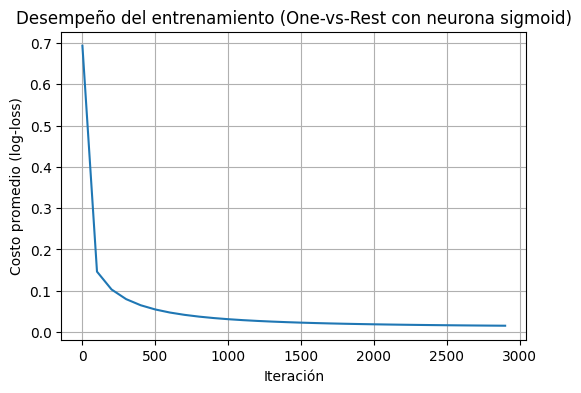

In [16]:
# === Entrenamiento multiclase usando la neurona (sigmoid) existente: One-vs-Rest ===

# Requiere que ya hayas ejecutado las celdas de "Implementación del modelo" (sigmoid, initialize_with_zeros, propagate, optimize).
required_fns = ["sigmoid", "initialize_with_zeros", "propagate", "optimize"]
missing = [fn for fn in required_fns if fn not in globals()]
if missing:
    raise RuntimeError(f"Faltan funciones: {missing}. Ejecuta primero las celdas de implementación del modelo.")

# Datos (features ya aplanadas) -> X: (n_features, m), Y: (1, m) con clases 0..K-1
X_train = train_set_x_flatten.astype(np.float32)
X_test = test_set_x_flatten.astype(np.float32)
Y_train_int = train_set_y.astype(int)
Y_test_int = test_set_y.astype(int)

K = int(np.max(np.concatenate([Y_train_int, Y_test_int], axis=1))) + 1
n_features = X_train.shape[0]

def train_one_vs_rest(
    X: np.ndarray,
    Y: np.ndarray,
    num_classes: int,
    num_iterations: int = 2000,
    learning_rate: float = 0.005,
    print_cost: bool = False,
    lambda_: float = 1.0,
 ):
    """
    Entrena num_classes clasificadores binarios (clase k vs resto) usando optimize().

    Regularización:
      - Se usa L2 (weight decay) con parámetro lambda_.
      - Si lambda_=0.0, queda igual que la versión sin regularización.

    Returns:
      W: (n_features, K)
      b: (K, 1)
      costs_per_class: lista de listas (cada una con costos cada 100 iters)
    """
    W = np.zeros((X.shape[0], num_classes), dtype=np.float32)
    b = np.zeros((num_classes, 1), dtype=np.float32)
    costs_per_class = []

    for k in range(num_classes):
        Yk = (Y == k).astype(int)  # (1, m) binario
        wk, bk = initialize_with_zeros(X.shape[0])
        params, grads, costs = optimize(
            wk,
            float(bk),
            X,
            Yk,
            num_iterations=num_iterations,
            learning_rate=learning_rate,
            print_cost=False,
            lambda_=lambda_,
        )
        W[:, k:k+1] = params["w"].astype(np.float32)
        b[k, 0] = float(params["b"])
        costs_per_class.append(costs)
        if print_cost:
            print(f"Clase {k}: último costo = {costs[-1] if len(costs) else None}")

    return W, b, costs_per_class

def predict_one_vs_rest(W: np.ndarray, b: np.ndarray, X: np.ndarray) -> np.ndarray:
    """
    W: (n_features, K), b: (K,1), X: (n_features, m)
    Return: y_pred (1, m) por argmax de probabilidades sigmoid
    """
    Z = (W.T @ X) + b  # (K, m)
    P = sigmoid(Z)      # (K, m) probas por clasificador
    return np.argmax(P, axis=0).reshape(1, -1)

# Entrenar OVR con la neurona existente
# Notas:
# - learning_rate más bajo para que sea menos agresivo
# - lambda_ agrega regularización L2 para reducir sobreajuste
W_ovr, b_ovr, costs_per_class = train_one_vs_rest(
    X_train, Y_train_int, K, num_iterations=3000, learning_rate=0.005, print_cost=True, lambda_=1.0
)

# Evaluación
Y_pred_train = predict_one_vs_rest(W_ovr, b_ovr, X_train)
Y_pred_test = predict_one_vs_rest(W_ovr, b_ovr, X_test)

train_acc = 100.0 * np.mean(Y_pred_train == Y_train_int)
test_acc = 100.0 * np.mean(Y_pred_test == Y_test_int)
print(f"Train accuracy (OVR + sigmoid): {train_acc:.2f}%")
print(f"Test accuracy  (OVR + sigmoid): {test_acc:.2f}%")

# Curva de desempeño: costo promedio entre clases (cada 100 iteraciones)
min_len = min(len(c) for c in costs_per_class) if costs_per_class else 0
if min_len > 0:
    costs_avg = np.mean(np.array([c[:min_len] for c in costs_per_class], dtype=np.float32), axis=0)
    xs = np.arange(min_len) * 100
    plt.figure(figsize=(6, 4))
    plt.plot(xs, costs_avg)
    plt.xlabel('Iteración')
    plt.ylabel('Costo promedio (log-loss)')
    plt.title('Desempeño del entrenamiento (One-vs-Rest con neurona sigmoid)')
    plt.grid(True)
    plt.show()
else:
    print("No hay suficientes puntos de costo para plottear.")

Cost after iteration 0: 2.302585
Cost after iteration 100: 0.059425
Cost after iteration 200: 0.050458
Cost after iteration 300: 0.047812
Cost after iteration 400: 0.046322
Cost after iteration 500: 0.045302
Cost after iteration 600: 0.044532
Cost after iteration 700: 0.043917
Cost after iteration 800: 0.043409
Cost after iteration 900: 0.042983
Cost after iteration 1000: 0.042620
Cost after iteration 1100: 0.042310
Cost after iteration 1200: 0.042042
Cost after iteration 1300: 0.041810
Cost after iteration 1400: 0.041609
Cost after iteration 1500: 0.041435
Cost after iteration 1600: 0.041283
Cost after iteration 1700: 0.041151
Cost after iteration 1800: 0.041036
Cost after iteration 1900: 0.040935
Cost after iteration 2000: 0.040847
Cost after iteration 2100: 0.040769
Cost after iteration 2200: 0.040701
Cost after iteration 2300: 0.040642
Cost after iteration 2400: 0.040589
Cost after iteration 2500: 0.040543
Cost after iteration 2600: 0.040502
Cost after iteration 2700: 0.040465
Cost

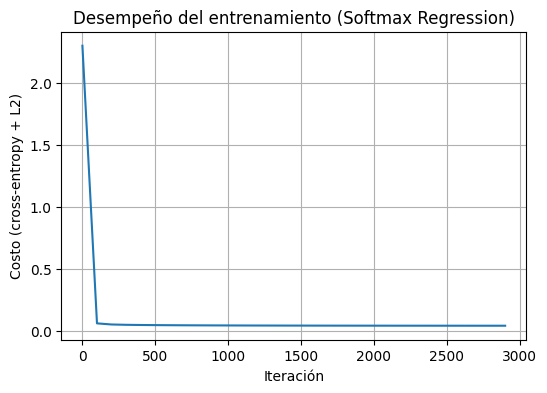

In [17]:
# === Entrenamiento multiclase usando Softmax (implementación propia) ===

"""
Esta sección implementa Softmax Regression desde cero, sin usar la neurona sigmoid ni optimize().
- softmax(Z): función de activación estable numéricamente.
- initialize_softmax(num_classes, n_features): inicializa W y b para Softmax.
- propagate_softmax(W, b, X, Y_int, lambda_): calcula costo (
cross-entropy + L2) y gradientes dW, db.
- optimize_softmax(X, Y_int, num_classes, ...): optimiza W y b usando propagate_softmax.
- predict_softmax(W, b, X): predice clase por argmax de probabilidades softmax.
"""

# Requiere que ya hayas ejecutado la celda de funciones Softmax en "Clases y funciones".
required_softmax = ["softmax", "optimize_softmax", "predict_softmax"]
missing_softmax = [fn for fn in required_softmax if fn not in globals()]
if missing_softmax:
    raise RuntimeError(f"Faltan funciones softmax: {missing_softmax}. Ejecuta primero la sección de Softmax en 'Clases y funciones'.")

# Usamos las mismas features aplanadas
X_train_sm = train_set_x_flatten.astype(np.float32)
X_test_sm = test_set_x_flatten.astype(np.float32)
Y_train_sm = train_set_y.astype(int)
Y_test_sm = test_set_y.astype(int)

K_sm = int(np.max(np.concatenate([Y_train_sm, Y_test_sm], axis=1))) + 1

# Hiperparámetros (moderados)
sm_learning_rate = 0.05
sm_lambda = 1.0
sm_iterations = 3000

params_sm, costs_sm = optimize_softmax(
    X_train_sm,
    Y_train_sm,
    num_classes=K_sm,
    num_iterations=sm_iterations,
    learning_rate=sm_learning_rate,
    lambda_=sm_lambda,
    print_cost=True,
 )

W_sm = params_sm["W"]
b_sm = params_sm["b"]

Y_pred_train_sm = predict_softmax(W_sm, b_sm, X_train_sm)
Y_pred_test_sm = predict_softmax(W_sm, b_sm, X_test_sm)

train_acc_sm = 100.0 * np.mean(Y_pred_train_sm == Y_train_sm)
test_acc_sm = 100.0 * np.mean(Y_pred_test_sm == Y_test_sm)
print(f"Train accuracy (Softmax): {train_acc_sm:.2f}%")
print(f"Test accuracy  (Softmax): {test_acc_sm:.2f}%")

# Curva de costo (cada 100 iteraciones)
if len(costs_sm) > 0:
    xs_sm = np.arange(len(costs_sm)) * 100
    plt.figure(figsize=(6, 4))
    plt.plot(xs_sm, costs_sm)
    plt.xlabel('Iteración')
    plt.ylabel('Costo (cross-entropy + L2)')
    plt.title('Desempeño del entrenamiento (Softmax Regression)')
    plt.grid(True)
    plt.show()
else:
    print("No hay suficientes puntos de costo para plottear.")

# Dataset Pokémon (original vs copia)

> Se carga desde `pokemon/train_labels.csv` y `pokemon/test_labels.csv`.
> 
> Formato esperado del CSV: `id,label` donde `id` es numérico (con o sin ceros a la izquierda) y la imagen se llama `N.JPG`.

In [18]:
from pathlib import Path
import csv
import numpy as np
from PIL import Image

def _resolve_pokemon_image_path(images_dir: Path, id_str: str) -> Path | None:
    """Resuelve el path de imagen para un id dado (con/sin padding)."""
    s = id_str.strip()
    candidates: list[str] = []
    # Caso más común: archivos 1.JPG, 2.JPG, ...
    try:
        candidates.append(f"{int(s)}.JPG")
        candidates.append(f"{int(s)}.jpg")
    except Exception:
        pass
    # Por si el dataset tuviera padding en el nombre
    candidates.append(f"{s}.JPG")
    candidates.append(f"{s}.jpg")
    for name in candidates:
        p = images_dir / name
        if p.is_file():
            return p
    return None

def load_pokemon_dataset(
    train_csv_path: str = "pokemon/train_labels.csv",
    test_csv_path: str = "pokemon/test_labels.csv",
    train_images_dir: str = "pokemon/train",
    test_images_dir: str = "pokemon/test",
    img_size: tuple[int, int] = (64, 64),
    normalize: bool = True,
 ):
    """
    Carga dataset binario Pokémon (0/1) a partir de CSVs separados (train/test).

    Retorna el mismo formato que `load_dataset()` para que puedas reusar el pipeline:
      - train_set_x_orig: (m_train, H, W, 3) float32
      - train_set_y: (1, m_train) int64
      - test_set_x_orig: (m_test, H, W, 3) float32
      - test_set_y: (1, m_test) int64
      - classes: (2,) array[str] ("0", "1")
    """
    train_csv_path = str(train_csv_path)
    test_csv_path = str(test_csv_path)
    train_images_dir_p = Path(train_images_dir)
    test_images_dir_p = Path(test_images_dir)

    def _load_split(csv_path: str, images_dir: Path) -> tuple[np.ndarray, np.ndarray, int]:
        X_list: list[np.ndarray] = []
        y_list: list[int] = []
        missing_count = 0
        with open(csv_path, "r", newline="") as f:
            reader = csv.DictReader(f)
            if reader.fieldnames is None or ("id" not in reader.fieldnames) or ("label" not in reader.fieldnames):
                raise ValueError(f"CSV must have columns 'id' and 'label'. Found: {reader.fieldnames}")
            for row in reader:
                img_path = _resolve_pokemon_image_path(images_dir, row["id"])
                if img_path is None:
                    missing_count += 1
                    continue
                img = Image.open(img_path)
                img = img.resize(img_size)
                if img.mode != "RGB":
                    img = img.convert("RGB")
                X_list.append(np.array(img, dtype=np.float32))
                y_list.append(int(row["label"]))
        if len(X_list) == 0:
            raise ValueError(f"No images loaded for split. Check {csv_path} and {images_dir}.")
        X = np.stack(X_list, axis=0)
        y = np.array(y_list, dtype=np.int64).reshape(1, -1)
        if normalize:
            X = X / 255.0
        return X, y, missing_count

    X_train_orig, y_train, miss_train = _load_split(train_csv_path, train_images_dir_p)
    X_test_orig, y_test, miss_test = _load_split(test_csv_path, test_images_dir_p)
    classes = np.array(["0", "1"])

    print(f"Pokemon train: {X_train_orig.shape}, {y_train.shape} (missing skipped: {miss_train})")
    print(f"Pokemon test : {X_test_orig.shape}, {y_test.shape} (missing skipped: {miss_test})")
    print("Class balance (train):", {0: int(np.sum(y_train==0)), 1: int(np.sum(y_train==1))})
    print("Class balance (test) :", {0: int(np.sum(y_test==0)), 1: int(np.sum(y_test==1))})

    return X_train_orig, y_train, X_test_orig, y_test, classes

def confusion_metrics_binary(y_true: np.ndarray, y_pred: np.ndarray) -> dict[str, float]:
    """y_true/y_pred: (1,m) con {0,1}. Retorna accuracy, precision, recall, f1."""
    yt = y_true.reshape(-1).astype(int)
    yp = y_pred.reshape(-1).astype(int)
    tp = int(np.sum((yt == 1) & (yp == 1)))
    tn = int(np.sum((yt == 0) & (yp == 0)))
    fp = int(np.sum((yt == 0) & (yp == 1)))
    fn = int(np.sum((yt == 1) & (yp == 0)))
    eps = 1e-12
    acc = (tp + tn) / max(1, (tp + tn + fp + fn))
    prec = tp / (tp + fp + eps)
    rec = tp / (tp + fn + eps)
    f1 = 2 * prec * rec / (prec + rec + eps)
    return {"accuracy": float(acc), "precision": float(prec), "recall": float(rec), "f1": float(f1), "tp": tp, "tn": tn, "fp": fp, "fn": fn}

Pokemon train: (373, 64, 64, 3), (1, 373) (missing skipped: 0)
Pokemon test : (78, 64, 64, 3), (1, 78) (missing skipped: 0)
Class balance (train): {0: 123, 1: 250}
Class balance (test) : {0: 28, 1: 50}
poke_train_x_flatten: (12288, 373)
poke_train_y: (1, 373)
poke_test_x_flatten: (12288, 78)
poke_test_y: (1, 78)
Cost after iteration 0: 0.693147
Cost after iteration 100: 0.748895
Cost after iteration 200: 0.620996
Cost after iteration 300: 0.516471
Cost after iteration 400: 0.426994
Cost after iteration 500: 0.348569
Cost after iteration 600: 0.279086
Cost after iteration 700: 0.218261
Cost after iteration 800: 0.172191
Cost after iteration 900: 0.155217
Cost after iteration 1000: 0.145990
Cost after iteration 1100: 0.137916
Cost after iteration 1200: 0.130763
Cost after iteration 1300: 0.124375
Cost after iteration 1400: 0.118634
Cost after iteration 1500: 0.113448
Cost after iteration 1600: 0.108741
Cost after iteration 1700: 0.104452
Cost after iteration 1800: 0.100529
Cost after ite

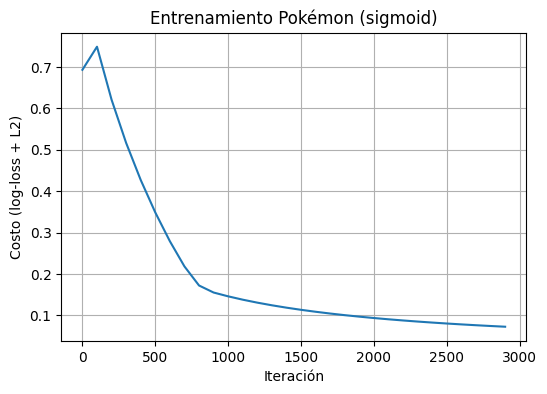

In [19]:
# === Carga + entrenamiento binario (sigmoid) en Pokémon ===

# 1) Cargar dataset Pokémon (binario)
poke_train_x_orig, poke_train_y, poke_test_x_orig, poke_test_y, poke_classes = load_pokemon_dataset(
    img_size=(64, 64),
    normalize=True,
 )

# 2) Flatten igual que antes: (m, H, W, 3) -> (H*W*3, m)
poke_train_x_flatten = poke_train_x_orig.reshape(poke_train_x_orig.shape[0], -1).T
poke_test_x_flatten = poke_test_x_orig.reshape(poke_test_x_orig.shape[0], -1).T

print("poke_train_x_flatten:", poke_train_x_flatten.shape)
print("poke_train_y:", poke_train_y.shape)
print("poke_test_x_flatten:", poke_test_x_flatten.shape)
print("poke_test_y:", poke_test_y.shape)

# 3) Entrenar con regularización L2 (lambda_) y LR moderado
d_poke = model(
    poke_train_x_flatten.astype(np.float32),
    poke_train_y.astype(int),
    poke_test_x_flatten.astype(np.float32),
    poke_test_y.astype(int),
    num_iterations=3000,
    learning_rate=0.005,
    lambda_=1.0,
    print_cost=True,
 )

# 4) Métricas extra (por desbalance)
m_train = confusion_metrics_binary(poke_train_y, d_poke["Y_prediction_train"])
m_test = confusion_metrics_binary(poke_test_y, d_poke["Y_prediction_test"])
print("\nTrain metrics:", m_train)
print("Test metrics :", m_test)

# 5) Curva de costo
if len(d_poke["costs"]) > 0:
    xs = np.arange(len(d_poke["costs"])) * 100
    plt.figure(figsize=(6, 4))
    plt.plot(xs, d_poke["costs"])
    plt.xlabel("Iteración")
    plt.ylabel("Costo (log-loss + L2)")
    plt.title("Entrenamiento Pokémon (sigmoid)")
    plt.grid(True)
    plt.show()

# Modelos con TensorFlow/Keras

> A continuación se implementan modelos equivalentes usando TensorFlow/Keras para comparar con las implementaciones manuales.
> 
> - **Clasificación multiclase (Flores)**: Red neuronal simple con softmax
> - **Clasificación binaria (Pokémon)**: Red neuronal simple con sigmoid

## Dataset Flores con TensorFlow (Multiclase)

Entrenando modelo TensorFlow (Flores - Multiclase)
Epoch 1/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.1369 - loss: 17.6353 - val_accuracy: 0.1429 - val_loss: 32.8205
Epoch 2/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.1250 - loss: 37.3335 - val_accuracy: 0.1667 - val_loss: 31.5445
Epoch 3/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.2083 - loss: 23.1260 - val_accuracy: 0.1667 - val_loss: 35.0365
Epoch 4/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.2143 - loss: 22.0509 - val_accuracy: 0.0952 - val_loss: 28.3386
Epoch 5/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.3095 - loss: 22.5411 - val_accuracy: 0.1905 - val_loss: 16.8252
Epoch 6/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.3988 - loss: 9.3305 - val_accuracy: 0.2381 - val_loss: 14.1387
Epoch 7/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.5179 - loss: 8.2292 - val_accuracy: 0.1905 - val_loss: 15.2793
Epoch 8/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0

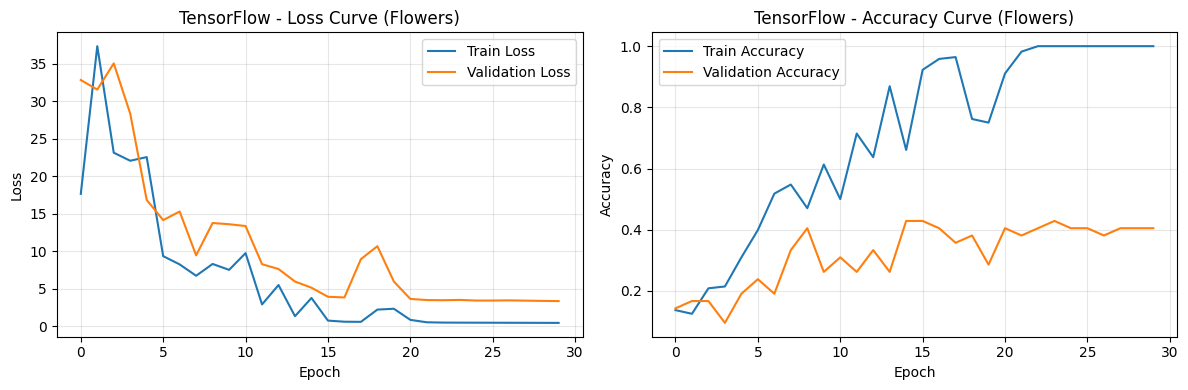

In [28]:
import os
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.regularizers import l2

os.makedirs('images', exist_ok=True)

X_train_keras = train_set_x_flatten.T.astype(np.float32)
X_test_keras = test_set_x_flatten.T.astype(np.float32)
y_train_keras = train_set_y.reshape(-1).astype(int)
y_test_keras = test_set_y.reshape(-1).astype(int)

num_classes_keras = K
n_features_keras = X_train_keras.shape[1]

model_flores = keras.Sequential([
    layers.Dense(num_classes_keras, activation='softmax', 
                 kernel_regularizer=l2(0.01), name='output_layer')
])

model_flores.compile(
    optimizer=keras.optimizers.SGD(learning_rate=0.05),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print("Entrenando modelo TensorFlow (Flores - Multiclase)")
history_flores = model_flores.fit(
    X_train_keras, y_train_keras,
    epochs=30, batch_size=32,
    validation_data=(X_test_keras, y_test_keras),
    verbose=1
)

train_loss_tf, train_acc_tf = model_flores.evaluate(X_train_keras, y_train_keras, verbose=0)
test_loss_tf, test_acc_tf = model_flores.evaluate(X_test_keras, y_test_keras, verbose=0)

print(f"\nResultados TensorFlow (Flores)")
print(f"Train accuracy: {train_acc_tf * 100:.2f}%")
print(f"Test accuracy: {test_acc_tf * 100:.2f}%")

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_flores.history['loss'], label='Train Loss')
plt.plot(history_flores.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('TensorFlow - Loss Curve (Flowers)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(history_flores.history['accuracy'], label='Train Accuracy')
plt.plot(history_flores.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('TensorFlow - Accuracy Curve (Flowers)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('images/tensorflow_flores_training.png', dpi=150, bbox_inches='tight')
plt.show()

## Dataset Pokémon con TensorFlow (Binario)

Entrenando modelo TensorFlow (Pokemon - Binario)
Epoch 1/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - accuracy: 0.5710 - loss: 1.8114 - precision_3: 0.6758 - recall_3: 0.6920 - val_accuracy: 0.6410 - val_loss: 2.5624 - val_precision_3: 0.6410 - val_recall_3: 1.0000
Epoch 2/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6434 - loss: 1.3464 - precision_3: 0.7159 - recall_3: 0.7760 - val_accuracy: 0.6410 - val_loss: 2.1603 - val_precision_3: 0.6410 - val_recall_3: 1.0000
Epoch 3/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6863 - loss: 1.1278 - precision_3: 0.7509 - recall_3: 0.7960 - val_accuracy: 0.6282 - val_loss: 0.8462 - val_precision_3: 0.8889 - val_recall_3: 0.4800
Epoch 4/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6971 - loss: 1.0598 - precision_3: 0.7686 - recall_3: 0.7840 - val_accuracy: 0.7692 - val_loss: 0.5086 - val_precision_3: 0.8077 - val_recall_3: 0.8400
Epoch 5/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7024 - loss: 0.869

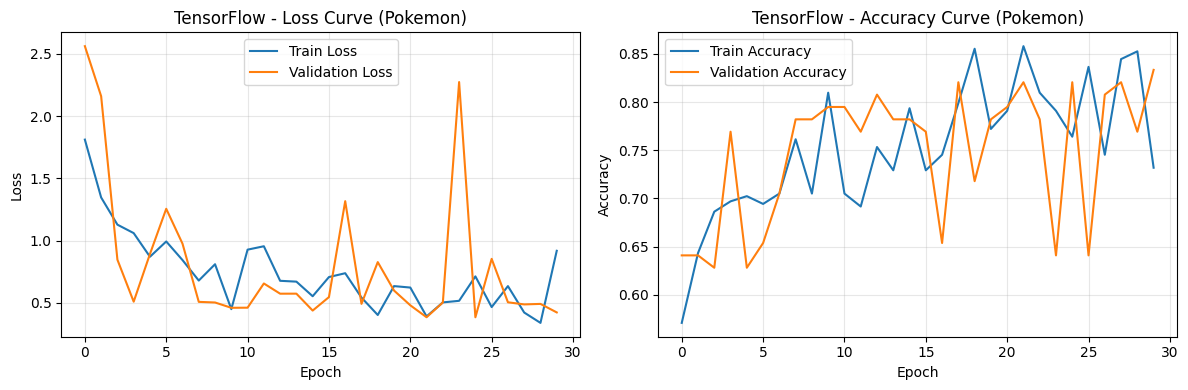

In [29]:
X_train_poke_keras = poke_train_x_flatten.T.astype(np.float32)
X_test_poke_keras = poke_test_x_flatten.T.astype(np.float32)
y_train_poke_keras = poke_train_y.reshape(-1).astype(np.float32)
y_test_poke_keras = poke_test_y.reshape(-1).astype(np.float32)

model_pokemon = keras.Sequential([
    layers.Dense(1, activation='sigmoid', 
                 kernel_regularizer=l2(0.01), name='output_layer')
])

model_pokemon.compile(
    optimizer=keras.optimizers.SGD(learning_rate=0.005),
    loss='binary_crossentropy',
    metrics=['accuracy', keras.metrics.Precision(), keras.metrics.Recall()]
)

print("Entrenando modelo TensorFlow (Pokemon - Binario)")
history_pokemon = model_pokemon.fit(
    X_train_poke_keras, y_train_poke_keras,
    epochs=30, batch_size=32,
    validation_data=(X_test_poke_keras, y_test_poke_keras),
    verbose=1
)

train_results_tf = model_pokemon.evaluate(X_train_poke_keras, y_train_poke_keras, verbose=0)
test_results_tf = model_pokemon.evaluate(X_test_poke_keras, y_test_poke_keras, verbose=0)

train_loss_poke_tf, train_acc_poke_tf, train_prec_tf, train_rec_tf = train_results_tf
test_loss_poke_tf, test_acc_poke_tf, test_prec_tf, test_rec_tf = test_results_tf

train_f1_tf = 2 * train_prec_tf * train_rec_tf / (train_prec_tf + train_rec_tf + 1e-12)
test_f1_tf = 2 * test_prec_tf * test_rec_tf / (test_prec_tf + test_rec_tf + 1e-12)

print(f"\nResultados TensorFlow (Pokemon)")
print(f"Train - Accuracy: {train_acc_poke_tf * 100:.2f}%, Precision: {train_prec_tf:.4f}, Recall: {train_rec_tf:.4f}, F1: {train_f1_tf:.4f}")
print(f"Test  - Accuracy: {test_acc_poke_tf * 100:.2f}%, Precision: {test_prec_tf:.4f}, Recall: {test_rec_tf:.4f}, F1: {test_f1_tf:.4f}")

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_pokemon.history['loss'], label='Train Loss')
plt.plot(history_pokemon.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('TensorFlow - Loss Curve (Pokemon)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(history_pokemon.history['accuracy'], label='Train Accuracy')
plt.plot(history_pokemon.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('TensorFlow - Accuracy Curve (Pokemon)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('images/tensorflow_pokemon_training.png', dpi=150, bbox_inches='tight')
plt.show()

# Comparación de Resultados

## Flores: Softmax vs TensorFlow

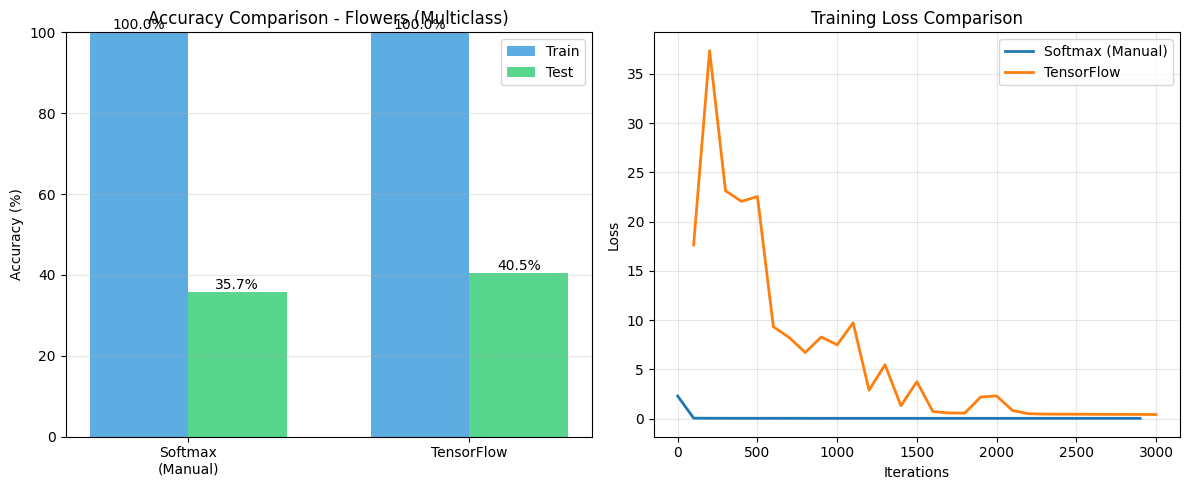

Softmax (Manual) - Train: 100.00%, Test: 35.71%
TensorFlow       - Train: 100.00%, Test: 40.48%


In [30]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

methods = ['Softmax\n(Manual)', 'TensorFlow']
train_accs = [train_acc_sm, train_acc_tf * 100]
test_accs = [test_acc_sm, test_acc_tf * 100]

x = np.arange(len(methods))
width = 0.35

bars1 = ax1.bar(x - width/2, train_accs, width, label='Train', color='#3498db', alpha=0.8)
bars2 = ax1.bar(x + width/2, test_accs, width, label='Test', color='#2ecc71', alpha=0.8)

ax1.set_ylabel('Accuracy (%)')
ax1.set_title('Accuracy Comparison - Flowers (Multiclass)')
ax1.set_xticks(x)
ax1.set_xticklabels(methods)
ax1.legend()
ax1.grid(axis='y', alpha=0.3)
ax1.set_ylim([0, 100])

for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}%', ha='center', va='bottom', fontsize=10)

if len(costs_sm) > 0:
    xs_softmax = np.arange(len(costs_sm)) * 100
    ax2.plot(xs_softmax, costs_sm, label='Softmax (Manual)', linewidth=2)
    
    epochs_tf = np.arange(len(history_flores.history['loss'])) + 1
    ax2.plot(epochs_tf * 100, history_flores.history['loss'], label='TensorFlow', linewidth=2)
    
    ax2.set_xlabel('Iterations')
    ax2.set_ylabel('Loss')
    ax2.set_title('Training Loss Comparison')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('images/comparison_flores.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"Softmax (Manual) - Train: {train_acc_sm:.2f}%, Test: {test_acc_sm:.2f}%")
print(f"TensorFlow       - Train: {train_acc_tf * 100:.2f}%, Test: {test_acc_tf * 100:.2f}%")

## Pokemon: Sigmoid vs TensorFlow

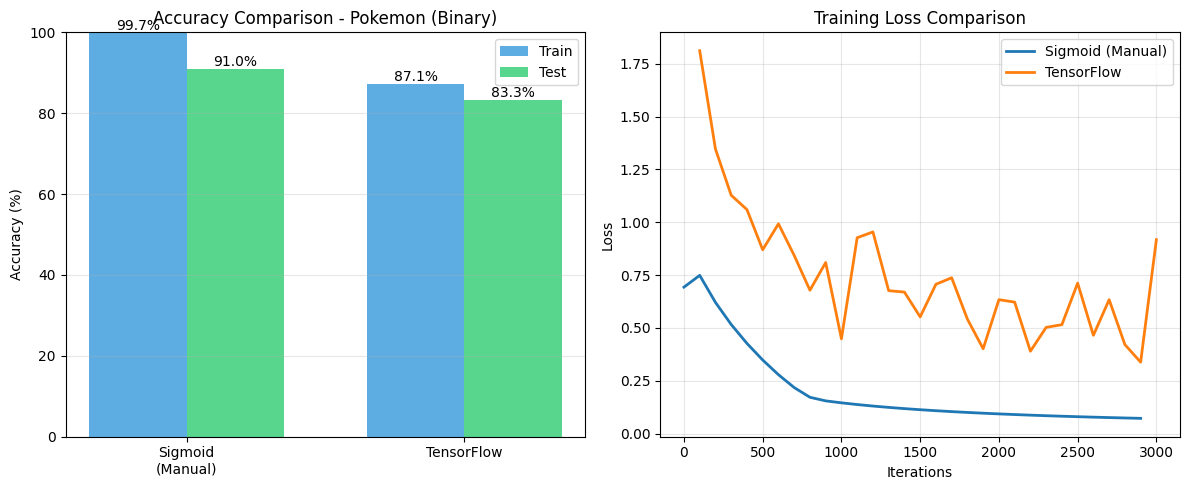

Sigmoid (Manual) - Train: 99.73%, Test: 91.03%, F1: 0.9346
TensorFlow       - Train: 87.13%, Test: 83.33%, F1: 0.8829


In [31]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

methods_poke = ['Sigmoid\n(Manual)', 'TensorFlow']
train_acc_poke = [m_train['accuracy'] * 100, train_acc_poke_tf * 100]
test_acc_poke = [m_test['accuracy'] * 100, test_acc_poke_tf * 100]
test_f1_poke = [m_test['f1'], test_f1_tf]

x = np.arange(len(methods_poke))
width = 0.35

bars1 = ax1.bar(x - width/2, train_acc_poke, width, label='Train', color='#3498db', alpha=0.8)
bars2 = ax1.bar(x + width/2, test_acc_poke, width, label='Test', color='#2ecc71', alpha=0.8)

ax1.set_ylabel('Accuracy (%)')
ax1.set_title('Accuracy Comparison - Pokemon (Binary)')
ax1.set_xticks(x)
ax1.set_xticklabels(methods_poke)
ax1.legend()
ax1.grid(axis='y', alpha=0.3)
ax1.set_ylim([0, 100])

for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}%', ha='center', va='bottom', fontsize=10)

if len(d_poke['costs']) > 0:
    xs_manual = np.arange(len(d_poke['costs'])) * 100
    ax2.plot(xs_manual, d_poke['costs'], label='Sigmoid (Manual)', linewidth=2)
    
    epochs_tf = np.arange(len(history_pokemon.history['loss'])) + 1
    ax2.plot(epochs_tf * 100, history_pokemon.history['loss'], label='TensorFlow', linewidth=2)
    
    ax2.set_xlabel('Iterations')
    ax2.set_ylabel('Loss')
    ax2.set_title('Training Loss Comparison')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('images/comparison_pokemon.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"Sigmoid (Manual) - Train: {train_acc_poke[0]:.2f}%, Test: {test_acc_poke[0]:.2f}%, F1: {test_f1_poke[0]:.4f}")
print(f"TensorFlow       - Train: {train_acc_poke[1]:.2f}%, Test: {test_acc_poke[1]:.2f}%, F1: {test_f1_poke[1]:.4f}")